# Tensorflow Implementation

## Setup

In [19]:
# Standard Library Imports
import time
import tracemalloc

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, 
    BatchNormalization, Activation
)
from tensorflow.keras.models import Sequential
from torchvision import transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.utils import shuffle
from ipywidgets import interact

# Project-Specific Imports
from MiraBest_F import MBFRFull
from FRDEEP import FRDEEPN, FRDEEPF


In [20]:
run = 3
batch_size = 32
imsize = 150
input_shape = (imsize, imsize, 1) 
random_state = 42
num_classes = 2

#### Function to show images

In [21]:
def show_image(index):
    plt.imshow(X_train_filtered[index])
    plt.title(y_train_filtered[index])
    plt.axis('off')
    plt.colorbar()
    plt.show()

#### Function to save metric to file

In [22]:
def save_metric(metric_name, value):
    file_path = os.path.join(base_path, f'{metric_name}.txt')
    with open(file_path, 'w') as f:
        f.write(str(value))
    print(f"{metric_name.capitalize()}:", value)

## Select Model and Dataset

In [23]:

class ModelDatasetSelector:
    def __init__(self, config):
        self.config = config
        self.batch_size = config['batch_size']
        
        rotate = transforms.RandomRotation([-180, 180])
        totensor = transforms.ToTensor()
        normalise = transforms.Normalize((0.0029,), (0.0341,)) 
        
        self.transforms = transforms.Compose([
            rotate,
            totensor,
            normalise
        ])
        
        self.test_transforms = transforms.Compose([
            totensor
        ])

    def get_dataset(self):
        dataset_map = {
            'mirabest': MBFRFull,
            'frdeep-n': FRDEEPN,
            'frdeep-f': FRDEEPF
        }
        dataset_class = dataset_map.get(self.config['dataset'])
        if not dataset_class:
            raise ValueError(f"Unknown dataset: {self.config['dataset']}")

        train_data = dataset_class(self.config['dataset'], download=True, train=True, transform=self.transforms)
        test_data = dataset_class(self.config['dataset'], download=True, train=False)

        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

        return train_data, test_data, train_loader, test_loader

    def get_model(self, input_shape):
        model_map = {
            'convxpress': lambda: convXpress(random_state, input_shape, num_classes),
            'toothless': lambda: toothless_real(random_state, input_shape, num_classes),
            'mcrgnet': lambda: mcrgnet(random_state, input_shape, num_classes),
            'first_class': lambda: first_class(random_state, input_shape, num_classes)
        }
        model_func = model_map.get(self.config['model'])
        if not model_func:
            raise ValueError(f"Unknown model: {self.config['model']}")

        return model_func()
    
    def get_epochs(self):
    # Map model names to their corresponding epoch counts
        epoch_map = {
            'convxpress': 100,
            'toothless': 30,
            'mcrgnet': 60,
            'first_class': 100
        }
        epochs = epoch_map.get(self.config['model'])
        if epochs is None:
            raise ValueError(f"Unknown model: {self.config['model']}")
        
        return epochs

In [24]:
config = {
    'dataset': 'frdeep-f',
    'model': 'convxpress',
    'batch_size': 32
}

selector = ModelDatasetSelector(config)
train_data, test_data, train_loader, test_loader = selector.get_dataset()

epochs = selector.get_epochs()
print(f"Training for {epochs} epochs.")

print(f"Selected dataset: {config['dataset']}")
print(f"Selected model: {config['model']}")
print(f"Train loader size: {len(train_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")

base_path = f"out/tensorflow/{config['dataset']}/{config['model']}/run_{run}"

Files already downloaded and verified
Files already downloaded and verified
Training for 100 epochs.
Selected dataset: frdeep-f
Selected model: convxpress
Train loader size: 550
Test loader size: 50


### Create train and test sets

In [25]:
X_train_filtered = np.array(train_data.data)
y_train_filtered = np.array(train_data.targets)
X_test_filtered = np.array(test_data.data)
y_test_filtered = np.array(test_data.targets)

## Visualize the dataset 

In [26]:
#interact(show_image, index=(0,len(X_train_filtered) - 1))

## Create the model

### conVxpress

In [27]:
def convXpress(random_state,input_shape,num_classes):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),strides=2,activation='relu',padding='same',input_shape=input_shape, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros',name='conv2d_input'))
    model.add(Conv2D(32, (3, 3),activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Conv2D(32, (3, 3),activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Dropout(0.25, seed=random_state))
    model.add(Conv2D(64, (3, 3),strides=2, activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.25, seed=random_state))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.25, seed=random_state))
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',name='final_output'))
    model.add(Dropout(0.25, seed=random_state))
    model.add(Flatten())
    model.add(Dense(500, activation='linear',kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.glorot_uniform(seed=random_state),bias_initializer='zeros'))
    model.add(Dropout(0.5, seed=random_state))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializers.glorot_uniform(seed=random_state),bias_initializer='zeros'))
    return model

### toothless

In [28]:
def toothless_real(random_state,input_shape,num_classes):
    
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11,11), padding='valid', strides=4,input_shape=input_shape, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=2,padding='valid'))
    
    model.add(Conv2D(256, (5, 5), padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2,padding='valid'))
    
    model.add(Conv2D(384, (3, 3), padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(384, (3, 3), padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2,padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(4096, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5, seed=random_state))
    model.add(Dense(4096, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5, seed=random_state))  
    model.add(Dense(num_classes, kernel_initializer=initializers.glorot_uniform(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('softmax'))
    return model

### mcrgNet

In [29]:
def mcrgnet(random_state,input_shape,num_classes):
    # Model name: MCRGNet (Morphological Classification of Radio Galaxy Network) 
    # Title: A Machine Learning Based Morphological Classification of 14,245 Radio AGN's Selected from the Best-Heckman Sample
    # Links to Article:
    # https://iopscience.iop.org/article/10.3847/1538-4365/aaf9a2
    # https://arxiv.org/pdf/1812.07190.pdf
    # Publication date: 5 Feb 2019
    # Primary Author: Zhixian Ma

    # Architecture description: (Page 5, figure 2 b) https://iopscience.iop.org/article/10.3847/1538-4365/aaf9a2/pdf#page=5

    # Source code link:
    # https://github.com/myinxd/MCRGNet/blob/master/mcrgnet/ConvAE.py


    # The architecture defined here is adapted from the article description and not the Github repo
    # for the purpose of clarity.
    
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3,3), strides = 2, activation='relu',padding='same',input_shape=input_shape, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Dropout(0.25, seed=random_state))
    
    model.add(Conv2D(8, (3, 3), strides = 2, activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Dropout(0.25, seed=random_state))
    
    model.add(Conv2D(16, (3, 3), strides = 2, activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Dropout(0.25, seed=random_state))
    
    model.add(Conv2D(16, (3, 3), strides = 2, activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Dropout(0.25, seed=random_state))
    
    model.add(Conv2D(32, (3, 3), strides = 2, activation='relu',padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Dropout(0.25, seed=random_state))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros')) 
    model.add(Dropout(0.25, seed=random_state))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializers.glorot_uniform(seed=random_state),bias_initializer='zeros'))
    return model

### firstClass

In [30]:
def first_class(random_state,input_shape,num_classes):
    # Original
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), padding='same',input_shape=input_shape, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros',name='conv2d_input'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(194, (3, 3), padding='same', kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,name='final_output'))
    model.add(Flatten())
    model.add(Dense(194, kernel_initializer=initializers.he_normal(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5,seed=random_state))
    model.add(Dense(num_classes, kernel_initializer=initializers.glorot_uniform(seed=random_state),bias_initializer='zeros'))
    model.add(Activation('softmax'))
    return model

## Switch to the CPU

In [31]:
# Use CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Double-check I'm running on CPU
tensor = tf.random.normal([3, 3])
print(f"Tensor is on device: {tensor.device}")

Tensor is on device: /job:localhost/replica:0/task:0/device:CPU:0


## Train the model

In [32]:
num_runs = 1
histories = []
model_reports = []

In [33]:
# Begin memory usage
tracemalloc.start()

In [34]:
# Begin timing  
start_time = time.time()

In [35]:
# Training
model = selector.get_model(input_shape) 
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
            metrics=['accuracy'])

history =  model.fit( 
X_train_filtered,
y_train_filtered,
validation_split = 0.2,
batch_size = 32,
epochs=epochs)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.4484 - loss: 99.1500 - val_accuracy: 0.4545 - val_loss: 13.6107
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.4868 - loss: 38.0945 - val_accuracy: 0.6727 - val_loss: 9.9066
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5268 - loss: 22.3898 - val_accuracy: 0.5000 - val_loss: 11.0383
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5406 - loss: 19.0606 - val_accuracy: 0.5364 - val_loss: 10.7187
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5313 - loss: 17.6856 - val_accuracy: 0.4636 - val_loss: 10.9109
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5187 - loss: 15.4225 - val_accuracy: 0.4000 - val_loss: 12.4169
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5638 - loss: 14.9929 - val_accuracy: 0.7091 - val_loss: 9.2072
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6053 - loss: 13.11

### Training time

In [36]:
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time = round(elapsed_time, 2)
print(f"The training took {elapsed_time} seconds.")

save_metric('train_time', elapsed_time)

The training took 243.69 seconds.
Train_time: 243.69


### Memory usage

In [37]:
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

peak_memory = peak / 10**6  # Convert to MB

save_metric('mem_use', peak)

Current memory usage: 65.43 MB
Peak memory usage: 67.39 MB
Mem_use: 67394193


### Save the model 

In [38]:
model.save(os.path.join(base_path, 'model.h5'))

## Predictions and Results

In [39]:
start_time = time.time()

In [40]:
predictions = model.predict(X_test_filtered)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


### Classification time

In [41]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"The predictions took {elapsed_time} seconds.")
elapsed_time = round(elapsed_time, 2)

save_metric('class_time', elapsed_time)

The predictions took 0.5014574527740479 seconds.
Class_time: 0.5


In [42]:
predicted = np.argmax(predictions, axis=1)

### Accuracy

In [43]:
accuracy = 100 * accuracy_score(y_test_filtered, predicted)
print("Accuracy:", accuracy)
accuracy = round(accuracy, 2)

save_metric('accuracy', accuracy)

Accuracy: 88.0
Accuracy: 88.0


### F1 Score

In [44]:
f1 = 100 * f1_score(y_test_filtered, predicted, average='weighted')
print("F1 Score:", f1)
f1 = round(f1, 2)

save_metric('f1', f1)

F1 Score: 88.03864734299516
F1: 88.04


### Confusion Matrrix

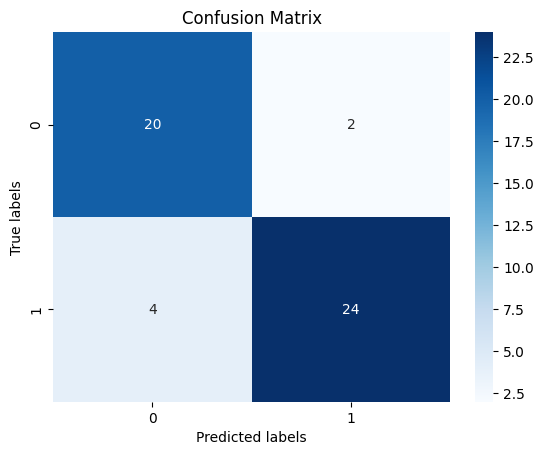

In [45]:
cm = confusion_matrix(y_test_filtered, predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(base_path, 'confusion_matrix.pdf'))
plt.show()

## Visualize Predictions 

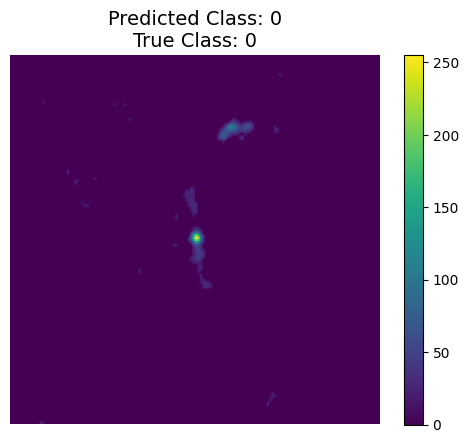

In [49]:
plt.imshow(X_test_filtered[2])
plt.title(f"Predicted Class: {predicted[2]}\nTrue Class: {y_test_filtered[2]}", fontsize=14)
plt.axis('off')
plt.colorbar()
plt.show()

## Training Results

In [47]:
for history in histories: 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss in Tensorflow')
    
    plt.savefig(os.path.join(base_path, 'training_results.pdf'))
    plt.close()